In [1]:
import sys
import os

# Go up to project root (from inside training/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '../.'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from core.utils import process_sample
from core.models.base_transformer_model import SimpleTransformerEncoder as BaseTransformerModel
from core.models.hierarchical_transformer import HierarchicalTransformer
import torch
import numpy as np
import os

In [3]:
# Initialize the models
htformer_weights = ".././models/final/hierarchical_transformer_f201_d64_h2_s1_t1_do0.1_20250701_2251.pth"
stformer_weights = ".././models/final/base_hierarchical_transformer_f201_d64_h2_do0.1_20250702_0105.pth"

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
htformer = HierarchicalTransformer(
    d_model=64,
    nhead=2,
    num_spatial_layers=1,
    num_temporal_layers=1,
    num_classes=3,
    num_joints=33,
    num_frames=201,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

htformer.load_state_dict(torch.load(htformer_weights))

# Base
stformer = BaseTransformerModel(
    d_model=64,
    nhead=2,
    num_layers=2,
    num_classes=3,
    num_joints=33,
    num_frames=201,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

stformer.load_state_dict(torch.load(stformer_weights))


<All keys matched successfully>

In [6]:
# Prepare the dataset
labels = {"squats": 0, "deadlifts": 1, "shoulder_press": 2}
temp_samples = []
sequence_lengths = []

# Load all samples
for exercise, label in labels.items():
    folder_path = os.path.join(".././data/keypoints/testing", exercise)
    if not os.path.exists(folder_path):
        print(f"Warning: {folder_path} does not exist")
        continue
        
    for file in os.listdir(folder_path):
        if file.endswith(".npy"):
            path = os.path.join(folder_path, file)
            try:
                sample = np.load(path)
                print(sample.shape)
                temp_samples.append((sample, label, file))
                sequence_lengths.append(sample.shape[0])
            except Exception as e:
                print(f"Error loading {path}: {e}")

if not temp_samples:
    raise ValueError("No samples loaded!")

# Determine max_frames using percentile to avoid extreme outliers
max_frames = 201

# Filter out sequences that are too long
filtered_samples = []
filtered_lengths = []
for i, (sample, label, filename) in enumerate(temp_samples):
    if sequence_lengths[i] <= max_frames:
        filtered_samples.append((sample, label, filename))
        filtered_lengths.append(sequence_lengths[i])
    else:
        print(f"Filtering out sample with length {sequence_lengths[i]}")

print(f"Kept {len(filtered_samples)} out of {len(temp_samples)} samples")

# Create padded arrays with attention masks
X = []
y = []
attention_masks = []
final_sequence_lengths = []

filenames = []  # to track filenames with final data

for sample, label, filename in filtered_samples:
    padded_sample, attention_mask, seq_len = process_sample(sample, max_frames)
    X.append(padded_sample)
    y.append(label)
    attention_masks.append(attention_mask)
    final_sequence_lengths.append(seq_len)
    filenames.append(filename)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
attention_masks = np.array(attention_masks)
final_sequence_lengths = np.array(final_sequence_lengths)

(247, 33, 4)
(93, 33, 4)
(110, 33, 4)
(74, 33, 4)
(135, 33, 4)
(78, 33, 4)
(126, 33, 4)
(80, 33, 4)
(73, 33, 4)
(96, 33, 4)
(108, 33, 4)
(79, 33, 4)
(83, 33, 4)
(110, 33, 4)
(120, 33, 4)
(120, 33, 4)
(39, 33, 4)
(49, 33, 4)
(105, 33, 4)
(79, 33, 4)
(86, 33, 4)
(80, 33, 4)
(80, 33, 4)
(120, 33, 4)
(108, 33, 4)
(113, 33, 4)
(89, 33, 4)
(70, 33, 4)
(108, 33, 4)
(104, 33, 4)
(93, 33, 4)
(108, 33, 4)
(101, 33, 4)
(111, 33, 4)
(74, 33, 4)
(93, 33, 4)
(154, 33, 4)
(84, 33, 4)
(158, 33, 4)
(103, 33, 4)
(86, 33, 4)
(86, 33, 4)
(70, 33, 4)
(109, 33, 4)
(89, 33, 4)
(90, 33, 4)
(111, 33, 4)
(77, 33, 4)
(63, 33, 4)
(87, 33, 4)
(65, 33, 4)
(75, 33, 4)
(85, 33, 4)
(97, 33, 4)
(89, 33, 4)
(93, 33, 4)
(80, 33, 4)
(80, 33, 4)
(119, 33, 4)
(62, 33, 4)
(75, 33, 4)
(60, 33, 4)
(91, 33, 4)
(78, 33, 4)
(82, 33, 4)
(84, 33, 4)
(94, 33, 4)
(102, 33, 4)
(72, 33, 4)
Filtering out sample with length 247
Kept 68 out of 69 samples


In [7]:
# Loaders
X = X[:, :, :, :3]# get x y z only

# Convert to PyTorch tensors
X_tensors = torch.tensor(X, dtype=torch.float32).to(device)
mask_tensor = torch.tensor(attention_masks, dtype=torch.float32).to(device)

In [8]:
X_tensors.shape, mask_tensor.shape

(torch.Size([68, 201, 33, 3]), torch.Size([68, 201]))

In [9]:
def infer(model, X: torch.tensor, mask: torch.tensor = None):
    model.eval()
    outputs = []

    with torch.no_grad():
        if mask is None:
            for x in X:
                x = x.unsqueeze(0)
                output = model(x)
                preds = output.argmax(1)
                outputs.extend(preds.cpu().numpy())
        else:
            for x, m in zip(X, mask):
                x = x.unsqueeze(0)
                m = m.unsqueeze(0)  # make sure mask is batched too
                output = model(x, m)
                preds = output.argmax(1)
                outputs.extend(preds.cpu().numpy())
    
    return outputs


In [10]:
# Perform inference for both models
htformer_outputs = infer(htformer, X_tensors, mask=mask_tensor)
stformer_outputs = infer(stformer, X_tensors, mask=None)

d:\Thesis\thesis\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

class_names = ['Squats', 'Deadlifts', 'Shoulder Press']

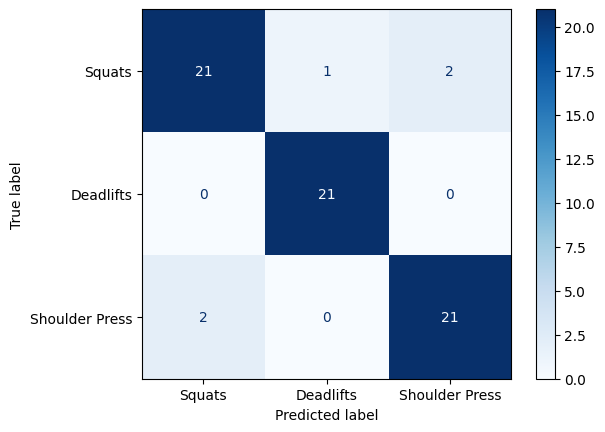

In [12]:
ConfusionMatrixDisplay.from_predictions(y, htformer_outputs,
                                        display_labels=class_names,
                                        cmap='Blues')

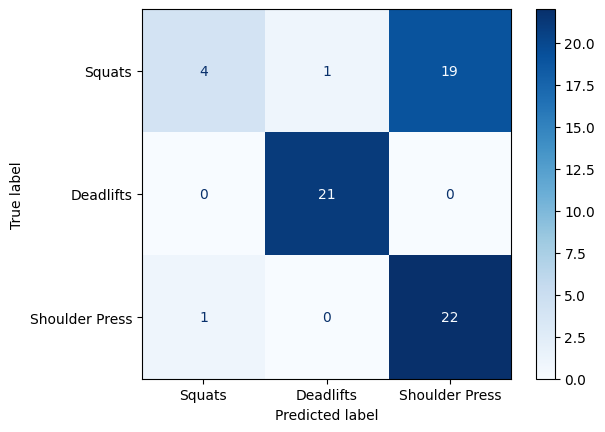

In [13]:
ConfusionMatrixDisplay.from_predictions(y, stformer_outputs,
                                        display_labels=class_names,
                                        cmap='Blues')

In [14]:
# reports
print("HTFormer Real World Data Inference")
print(classification_report(y, htformer_outputs))
print("-----------------------------------------------------")
print("STFormer Real World Data Inference")
print(classification_report(y, stformer_outputs))

HTFormer Real World Data Inference
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        24
           1       0.95      1.00      0.98        21
           2       0.91      0.91      0.91        23

    accuracy                           0.93        68
   macro avg       0.93      0.93      0.93        68
weighted avg       0.93      0.93      0.93        68

-----------------------------------------------------
STFormer Real World Data Inference
              precision    recall  f1-score   support

           0       0.80      0.17      0.28        24
           1       0.95      1.00      0.98        21
           2       0.54      0.96      0.69        23

    accuracy                           0.69        68
   macro avg       0.76      0.71      0.65        68
weighted avg       0.76      0.69      0.63        68



In [15]:
# Identify misclassified indices for each model
htformer_misclassified_indices = [i for i, (pred, true) in enumerate(zip(htformer_outputs, y)) if pred != true]
stformer_misclassified_indices = [i for i, (pred, true) in enumerate(zip(stformer_outputs, y)) if pred != true]

# Print them
print("HTFormer Misclassified Indices:", htformer_misclassified_indices)
print("STFormer Misclassified Indices:", stformer_misclassified_indices)

HTFormer Misclassified Indices: [0, 15, 16, 54, 60]
STFormer Misclassified Indices: [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 60]


In [16]:
# Example for HTFormer
for i, (pred, true) in enumerate(zip(htformer_outputs, y)):
    if pred != true:
        print(f"Misclassified by HTFormer - File: {filenames[i]}, True: {class_names[true]}, Predicted: {class_names[pred]}")

Misclassified by HTFormer - File: squats_1.npy, True: Squats, Predicted: Shoulder Press
Misclassified by HTFormer - File: squats_23.npy, True: Squats, Predicted: Shoulder Press
Misclassified by HTFormer - File: squats_24.npy, True: Squats, Predicted: Deadlifts
Misclassified by HTFormer - File: shoulder_press_17.npy, True: Shoulder Press, Predicted: Squats
Misclassified by HTFormer - File: shoulder_press_22.npy, True: Shoulder Press, Predicted: Squats


In [ ]:
for i, (pred, true) in enumerate(zip(stformer_outputs, y)):
    if pred != true:
        print(f"Misclassified by STFormer - File: {filenames[i]}, True: {class_names[true]}, Predicted: {class_names[pred]}")


Misclassified by STFormer - File: squats_11.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_12.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_13.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_14.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_15.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_16.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_17.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_18.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_19.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_20.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFormer - File: squats_21.npy, True: Squats, Predicted: Shoulder Press
Misclassified by STFo

: 